In [35]:
# autoreload
%load_ext autoreload
%autoreload 2

import os

while ".gitignore" not in os.listdir():
    parent = os.path.dirname(os.getcwd())
    os.chdir(parent)
print(f"Working directory: {os.getcwd()}")
import wandb
import torch
import numpy as np
import scanpy as sc

from spatialnca.train import train

from spatialnca.config import Config
from spatialnca.utils import animate_trajectory, spatial_scatter, load_wandb_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Working directory: /home/dschaub/projects/spatialnca


In [36]:
def func(eps, r):
    return -np.log(eps) / (r**2)


func(1e-3, 0.025)

np.float64(11052.408446371417)

### Setup with dynamic graph

In [37]:
default_cfg = Config()
cfg = Config()
# cfg.emb_key = None
cfg.add_init = True
# cfg.act = "gelu"
# cfg.gpt2_weight_init = True
# cfg.pos_init_fn = "uniform"
# cfg.pos_init_fn = "sunflower"
# cfg.dynamic_edges = True
# cfg.n_static_warmup_steps = 1000
# cfg.edge_update_steps = 2
# cfg.use_orig_graph = False  # use the initial graph for the first n_static_warmup_steps
cfg.clip_value = 1.0
# cfg.lr = 1e-2
# cfg.warmup_iters = 1000
# cfg.n_epochs = int(1e6)
cfg.n_epochs = 10000
# cfg.intm_loss = True
# cfg.pos_init_kwargs = {"scale": 0.1}
# cfg.normalize_diff = True
# cfg.max_coord_upd_norm = 0.75
cfg.complete = True
# cfg.delaunay = True
# cfg.knn = 5
# cfg.pos_init_fn = "random_walk"
# cfg.pos_init_kwargs = {"scale": 0.1}
cfg.n_steps = 5
cfg.kernel_fn = "gaussian"
cfg.kernel_kwargs = {"sigma": 1.0, "eps": 1e-3, "radius": 0.05}
cfg.use_attn = True
# cfg.aggr = "mean"

### Setup with complete graph

In [38]:
default_cfg = Config()
cfg = Config()
cfg.add_init = True
cfg.clip_value = 1.0
# cfg.lr = 1e-2
cfg.n_epochs = 10
cfg.max_coord_upd_norm = 0.05
cfg.complete = True
# cfg.n_steps = 30
cfg.pos_init_kwargs = {"scale": 0.05}
cfg.kernel_fn = "gaussian"
cfg.kernel_kwargs = {"eps": 1e-2, "max_radius": 0.05}
cfg.use_attn = True
cfg.scale_by_dist = True
# cfg.alpha_decay = True
# cfg.aggr = "mean"
cfg.watch = True
cfg.plot_init_pos = True

In [39]:
default_cfg = Config()
cfg = load_wandb_config("dschaub/spatialnca/lzhdh114")
cfg.pos_init_kwargs = {"scale": 0.05}
cfg.delaunay = True
cfg.knn = None

In [40]:
diff = cfg - default_cfg
if len(diff) > 0:
    diff_str = ",\n".join([f"{k}={v}" for k, v in diff.items()])
else:
    diff_str = "Default config"
clean_diff_str = diff_str.replace(", ", "_").replace("\n", "_")
print(diff_str)

warmup_iters=0->1000,
clip_value=1.0->0.25,
pos_init_kwargs=None->{'scale': 0.05},
dynamic_edges=False->True,
n_static_warmup_steps=0->500,
use_orig_graph=True->False,
edge_update_steps=1->2,
add_init=False->True,
knn=10->None,
delaunay=False->True,
max_coord_upd_norm=None->0.75


Constructed graph with 318 nodes and 1880 edges


Training:   0%|          | 0/10000 [00:00<?, ?it/s]

epoch,▁▁▁▁▁▂▂▂▂▃▃▃▃▃▃▃▃▃▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇██
train_loss,▇▃▁█▇▅▅▅▅▅▅▄▅▄▅▆▆▆▅▅▄▆▅▄▄▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃
epoch,9999
train_loss,0.00683


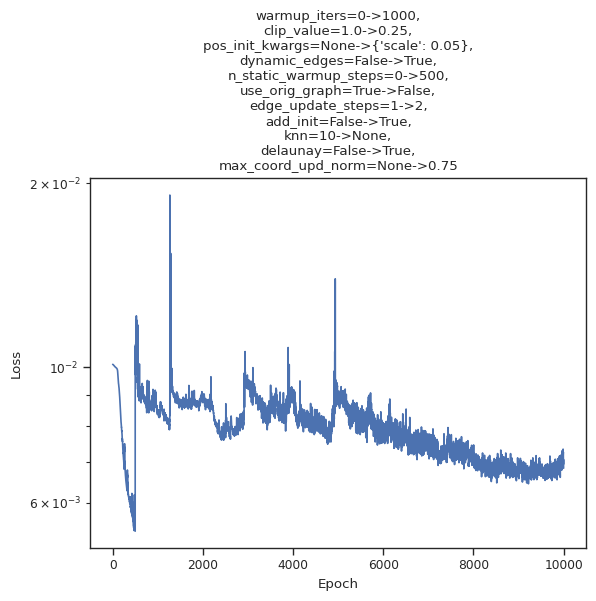

In [41]:
# wandb.finish()
os.environ["WANDB_MODE"] = "disabled"
os.environ["WANDB_MODE"] = "online"
# os.environ["WANDB_DISABLED"] = "true"

trainer = train(cfg, print_cfg=False)

os.makedirs("figures", exist_ok=True)
os.makedirs("checkpoints", exist_ok=True)

trainer.plot_history(
    title=diff_str, save_path=f"figures/history_{clean_diff_str[0:50]}.png"
)

# torch.save(trainer.model, f"checkpoints/trained_model_{clean_diff_str[0:50]}.pt")

In [31]:
# perform another rollout to check the result
n_steps = cfg.n_steps

model = trainer.model
data = trainer.data

states = model.rollout(
    x=data.x,
    pos=data.pos_init,
    n_steps=n_steps,
    edge_index=data.edge_index_init,
    return_evolution=True,
    prog_bar=True,
    dynamic_edges=cfg.dynamic_edges,
)
positions = np.array([state["pos"] for state in states])
positions.shape

pos = states[-1]["pos"].to(trainer.device)
loss = trainer.compute_loss(pos)
loss

Rollout:   0%|          | 0/5 [00:00<?, ?it/s]

tensor(0.0086, device='cuda:0')

In [32]:
# usage
animate_trajectory(
    positions,
    interpolation_steps=30,
    out_path="figures/positions_dynamic_latest_v2.mp4",
    # colors=set_color(adata, "subclass"),
)

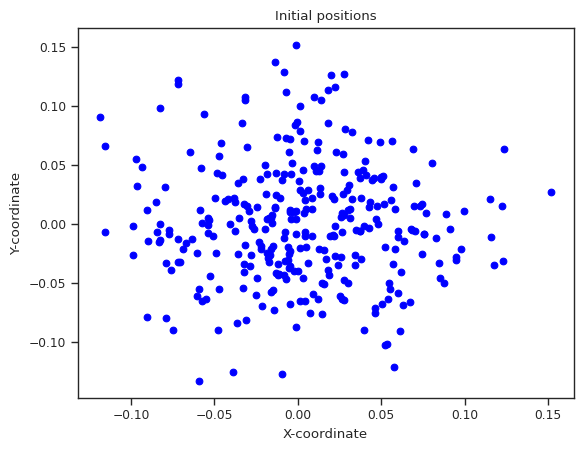

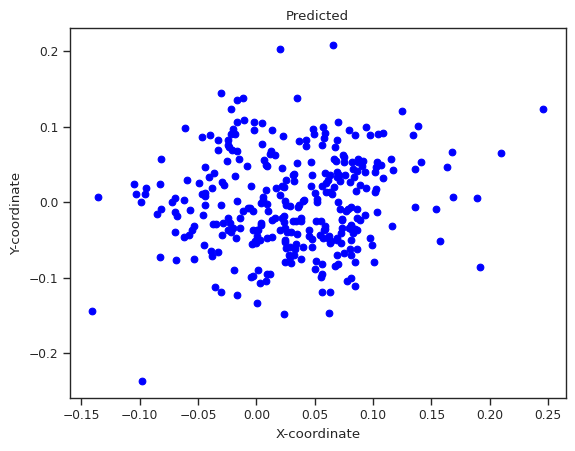

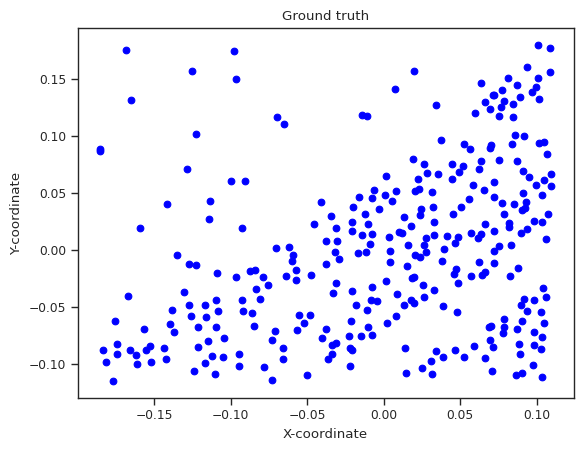

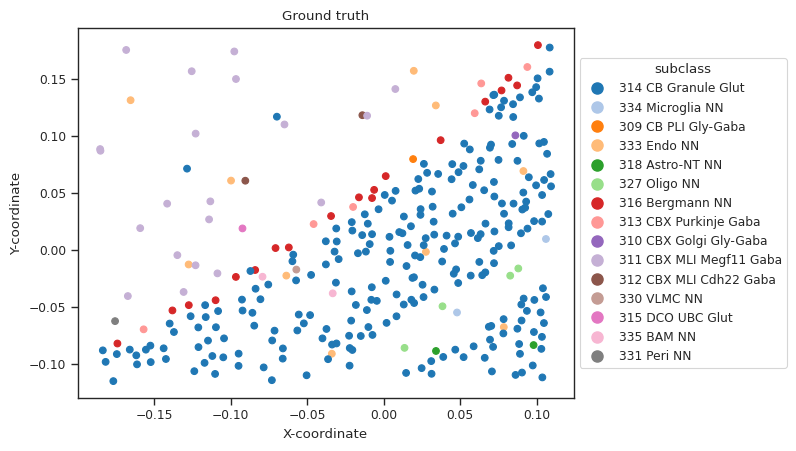

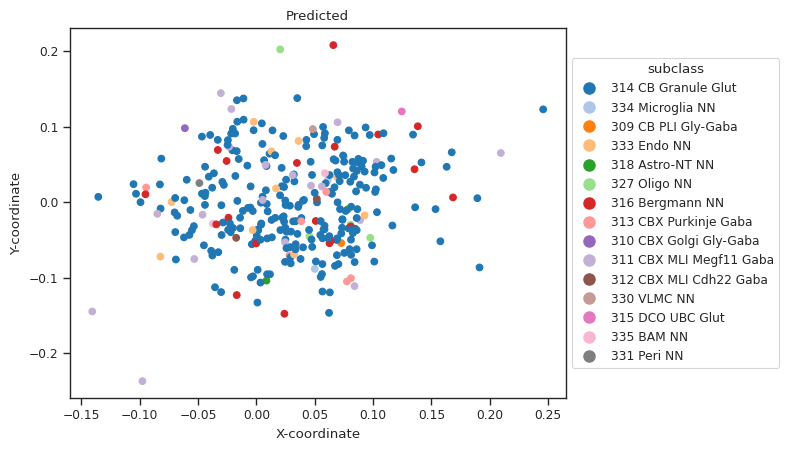

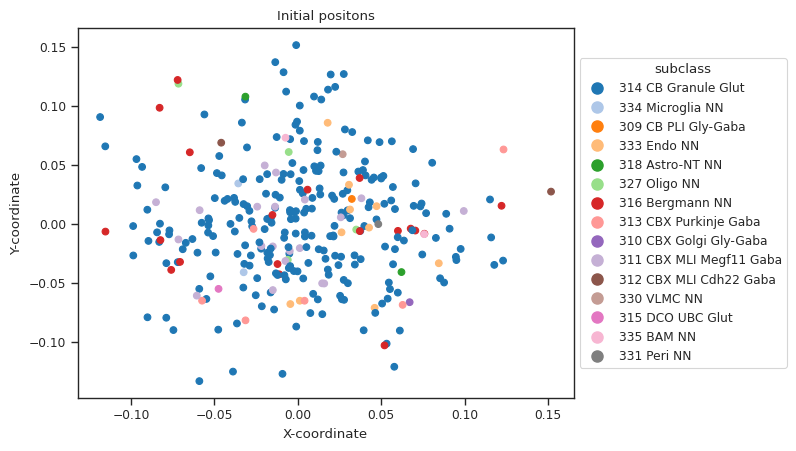

In [33]:
# perform another rollout to check the result
adata = sc.read_h5ad(cfg.path)

# convert to anndata for plotting
ad_init = adata.copy()
ad_init.obsm["spatial"] = data.pos_init.cpu().detach().numpy()

ad_final = adata.copy()
ad_final.obsm["spatial"] = pos.cpu().detach().numpy()


spatial_scatter(ad_init, color=None, title="Initial positions")
spatial_scatter(ad_final, color=None, title="Predicted")
spatial_scatter(adata, color=None, title="Ground truth")

col = "celltype_l1"
col = "subclass"

if col in adata.obs.columns:
    spatial_scatter(adata, color=col, title="Ground truth")
    spatial_scatter(ad_final, color=col, title="Predicted")
    spatial_scatter(ad_init, color=col, title="Initial positons")